<a href="https://colab.research.google.com/github/tejyash/AI-Land-Cover-Classification/blob/main/AI_Land_Use_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Setup & Config + Tarun's Preprocesing**

In [ ]:
# IMPORTS & CONFIGURATION
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import osgeo
from osgeo import gdal
import pandas as pd

# Tej's Proposed Change for Tarun's Dataset: fixing random seeds for full reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# **2.Tarun's Data Loading & Validation**

In [ ]:
# Hardeep: Downloaded the dataset using this code for efficiency
import kagglehub
# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eurosat-dataset


In [ ]:
# DEFINE & VALIDATE DATA PATH
# data_dir = os.path.join(os.getcwd(), 'data', 'raw')
data_dir = f"{path}/EuroSATallBands" # Hardeep

# Tej's Proposed Change: check dataset existence early to avoid issues later
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"Data directory not found: {data_dir}")
print("Classes found:", os.listdir(data_dir))

Classes found: ['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'validation.csv', 'AnnualCrop', 'train.csv', 'test.csv', 'label_map.json', 'Forest', 'HerbaceousVegetation']


**3. Tarun's Compute Dataset Mean & Std**

In [ ]:
# Hardeep - created custom dataset class to allow calculating per-channel statistics
class DatasetForStats(Dataset):

  def __init__(self, root, labels, transform=None):
    self.root = root
    self.labels = pd.read_csv(labels)
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img_file = self.labels.iloc[idx, 0]
    img_path = os.path.join(self.root, img_file)
    image = gdal.Open(img_path)
    bands = [""] * 13
    for i in range(13):
      bands[i] = image.GetRasterBand(i+1)
      bands[i] = bands[i].ReadAsArray()
      bands[i] = torch.from_numpy(bands[i])
    return bands

In [ ]:
# CALCULATE PER‑CHANNEL MEAN/STD (RGB)
stats_transform = transforms.Compose([
    transforms.Resize((64,64)),
])
dataset_for_stats = DatasetForStats(
    root = data_dir, labels = f"{data_dir}/train.csv", transform = None
)
# Hardeep - changed num workers to 2 and changed batch size to 32
loader_stats = DataLoader(dataset_for_stats, batch_size=32, shuffle=False, num_workers=2)
# Hardeep - made means and stds into lists
means = [0] * 13
stds  = [0] * 13
nb_samples = [0] * 13

for bands in loader_stats:
  for i in range(13):
    band = bands[i]
    batch_samples = band.size(0)
    band = band.view(batch_samples, band.size(1), -1)
    band = band.float()
    means[i] += torch.mean(band)
    stds[i]  += torch.std(band)
    nb_samples[i] += batch_samples

# Hardeep - prints mean and std per band
for i in range(13):
  means[i] /= nb_samples[i]
  stds[i]  /= nb_samples[i]
  print("Computed mean:", means[i].item())
  print("Computed std: ", stds[i].item())

Computed mean: 42.33356475830078
Computed std:  7.421943664550781
Computed mean: 34.87467956542969
Computed std:  10.12856674194336
Computed mean: 32.307899475097656
Computed std:  12.140202522277832
Computed mean: 29.226303100585938
Computed std:  18.232240676879883
Computed mean: 36.90873718261719
Computed std:  17.64769172668457
Computed mean: 61.43389129638672
Computed std:  27.19117546081543
Computed mean: 72.7497787475586
Computed std:  34.214168548583984
Computed mean: 70.4899673461914
Computed std:  35.16450881958008
Computed mean: 22.613801956176758
Computed std:  12.351040840148926
Computed mean: 0.41103067994117737
Computed std:  0.23727059364318848
Computed mean: 55.6640510559082
Computed std:  31.545873641967773
Computed mean: 34.32841873168945
Computed std:  23.529285430908203
Computed mean: 79.51321411132812
Computed std:  38.938079833984375


In [ ]:
# Hardeep - made custom dataset class to be main dataset class
class ImageClassificationDataset(Dataset):

  def __init__(self, root, labels, transform=None):
    self.root = root
    self.labels = pd.read_csv(labels)
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img_file = self.labels.iloc[idx, 0]
    img_path = os.path.join(self.root, img_file)
    image = gdal.Open(img_path)
    bands = [""] * 13
    for i in range(13):
      bands[i] = image.GetRasterBand(i+1)
      bands[i] = bands[i].ReadAsArray()
    image = np.stack(bands)
    image = torch.from_numpy(image)
    image = image.float()
    label = self.labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    return image, label

**4. Transforms & Augmentation**

In [ ]:
# SET UP TRANSFORMS USING COMPUTED mean/std

train_transform = transforms.Compose([
    transforms.Resize((64,64)),

    # Tej's Addition: stronger augmentations added

    transforms.RandomResizedCrop(64, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Normalize(means, stds)
])

test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Normalize(means, stds)
])

**5. Train/Val/Test Split**

In [ ]:
# Hardeep - created new train, val and test sets to reflect splits provided in EuroSAT
train_dataset = ImageClassificationDataset(
    root = data_dir, labels = f"{data_dir}/train.csv", transform = train_transform
)
val_dataset = ImageClassificationDataset(
    root = data_dir, labels = f"{data_dir}/validation.csv", transform = test_transform
)
test_dataset = ImageClassificationDataset(
    root = data_dir, labels = f"{data_dir}/test.csv", transform = test_transform
)

In [ ]:
#  SPLITTING INTO TRAIN, VAL, TEST

# full_dataset = datasets.ImageFolder(root=data_dir)
# targets = np.array(full_dataset.targets)

# # 10% hold‑out test
# train_val_idx, test_idx = train_test_split(
#     np.arange(len(targets)),
#     test_size=0.1,
#     stratify=targets,
#     random_state=seed
# )

# # From remaining 90%, 20% → validation
# train_idx, val_idx = train_test_split(
#     train_val_idx,
#     test_size=0.2,
#     stratify=targets[train_val_idx],
#     random_state=seed
# )

# # Build Subsets with appropriate transforms
# train_dataset = Subset(
#     datasets.ImageFolder(root=data_dir, transform=train_transform),
#     train_idx
# )
# val_dataset = Subset(
#     datasets.ImageFolder(root=data_dir, transform=test_transform),
#     val_idx
# )
# test_dataset = Subset(
#     datasets.ImageFolder(root=data_dir, transform=test_transform),
#     test_idx
# )

print(f"Train: {len(train_dataset)} samples")
print(f"Val:   {len(val_dataset)} samples")
print(f"Test:  {len(test_dataset)} samples")

Train: 19317 samples
Val:   5519 samples
Test:  2759 samples


**6. Creating the Dataloaders**

In [ ]:
batch_size = 32
num_workers = min(4, os.cpu_count()//2)  # Tej's Proposed: adapting to CPU cores

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

**Hardeep's ResNet Setup**

In [ ]:
# LOAD & ADAPT ResNet50
# num_classes = len(full_dataset.classes)
num_classes = 10

model = models.resnet50(pretrained=True)
# Tej's Proposed Option (to be discussed on MOnday): freeze early layers (if needed)
for param in model.parameters():
    param.requires_grad = True  # set False to freeze them

# Replace final layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
# Hardeep - Changed input to first convolutional layer from 3 to 13 channels
model.conv1 = nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #
model = model.to(device)

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

**Tej's Training Loop Setup**

In [ ]:
# DEFINE CRITERION, OPTIMISER, SCHEDULER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, verbose=True
)

# Early‑stopping & checkpointing
best_val_loss = float('inf')
patience, trials = 5, 0
checkpoint_path = '/content/models/resnet50_best.pth' # Hardeep

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


**Tej's Training & Validation Functions**

In [ ]:
# 9. TRAIN/VALIDATE EPOCH FUNCTIONS
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

**Tej's Main Training Loop**

In [ ]:
# RUN TRAINING
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping—no improvement in validation loss.")
            break

Epoch 1/20 | Train Loss: 0.5152, Train Acc: 0.8309 | Val Loss:   0.2719, Val Acc:   0.9098
Epoch 2/20 | Train Loss: 0.2643, Train Acc: 0.9131 | Val Loss:   0.3478, Val Acc:   0.8781
Epoch 3/20 | Train Loss: 0.2070, Train Acc: 0.9328 | Val Loss:   0.3015, Val Acc:   0.9123
Epoch 4/20 | Train Loss: 0.1690, Train Acc: 0.9445 | Val Loss:   0.1661, Val Acc:   0.9451
Epoch 5/20 | Train Loss: 0.1471, Train Acc: 0.9500 | Val Loss:   0.1516, Val Acc:   0.9554
Epoch 6/20 | Train Loss: 0.1275, Train Acc: 0.9590 | Val Loss:   0.1079, Val Acc:   0.9652
Epoch 7/20 | Train Loss: 0.1175, Train Acc: 0.9610 | Val Loss:   0.1835, Val Acc:   0.9420
Epoch 8/20 | Train Loss: 0.1046, Train Acc: 0.9661 | Val Loss:   0.1174, Val Acc:   0.9629
Epoch 9/20 | Train Loss: 0.1033, Train Acc: 0.9649 | Val Loss:   0.1024, Val Acc:   0.9683
Epoch 10/20 | Train Loss: 0.0939, Train Acc: 0.9684 | Val Loss:   0.1085, Val Acc:   0.9650
Epoch 11/20 | Train Loss: 0.0826, Train Acc: 0.9721 | Val Loss:   0.1414, Val Acc:   0.95

**Tej's Visualissations**

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x797bc0778540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
     

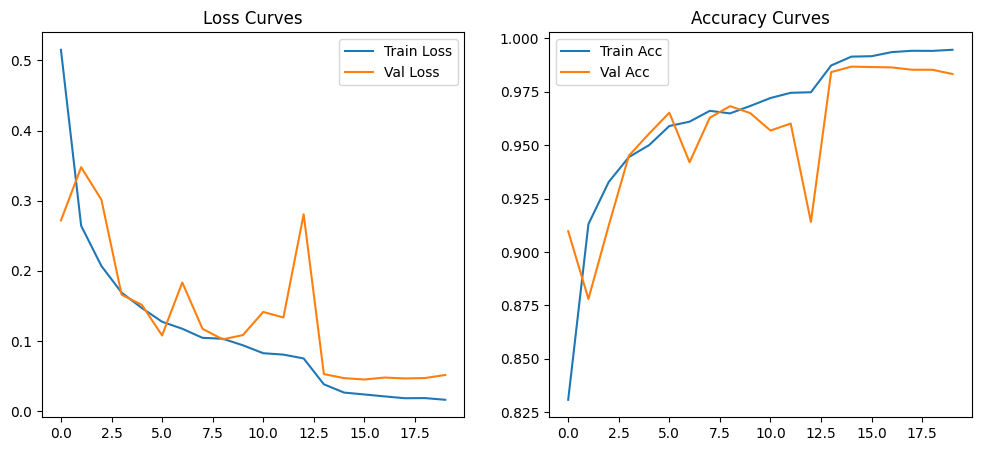

In [ ]:
# VISUALISE LOSS & ACCURACY
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs,   label='Val Acc')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

**Tej's Test Set's Evaluation MEtrics**

In [ ]:
# LOAD BEST MODEL & EVALUATE ON TEST SET
model.load_state_dict(torch.load(checkpoint_path))
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0549, Test Accuracy: 0.9851
